In [11]:
import pandas as pd
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import scatter_matrix
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

## Time Series Modeling

dataset: timeSeries4.csv 

In order to model the dataset, we decided to plot the data in the first place. This will allow us to spot trend and seasonality patterns and outliers.

In [34]:
colnames = ['Time','Data']
data_ts = pd.read_csv('timeSeries4.csv',names=colnames, header=None)
data_ts['Date'] = pd.date_range(start='1/1/2000', periods=len(data_ts), freq='M')
data_ts.drop(['Time'], axis=1,inplace = True)
data_ts.set_index('Date',inplace=True)
data_ts.head()

,Data
Date,
2000-01-31,21.684748
2000-02-29,21.622112
2000-03-31,19.583297
2000-04-30,23.290602
2000-05-31,21.729621


The plots below highlight the following:

- Growing trend is evident in the annual series
- Seasonal patterns are revealed in the boxplot. There is a clear drop in the data in month three and a softer one in month twelve.
- Oulier present in January 2001

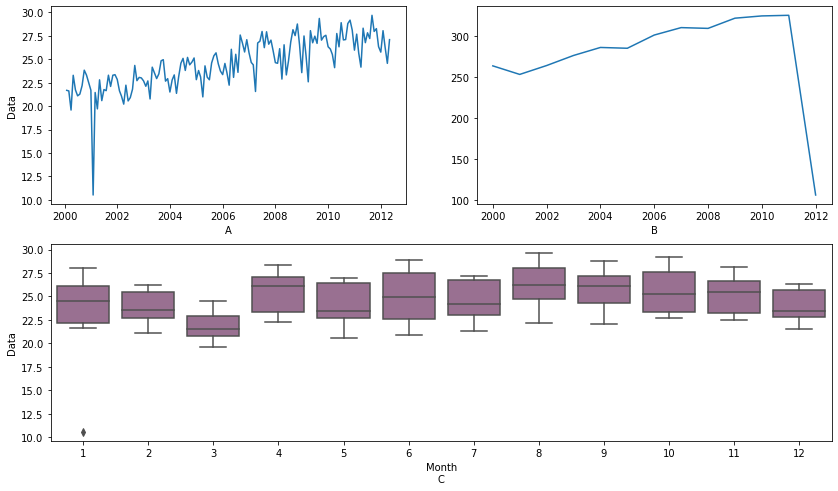

In [17]:
#Trend spotting
f, axs = plt.subplots(2,2,figsize=(14,8))

plt.subplot(221)
plt.plot(data_ts.Data)
plt.xlabel('A')
plt.ylabel("Data")

plt.subplot(222)
plt.xlabel('B')
plt.plot(data_ts.groupby([(data_ts.index.year)]).sum())


plt.subplot(212)
sns.boxplot(data_ts.index.month, data_ts['Data'], color="#A06995")
plt.xlabel("Month\nC");

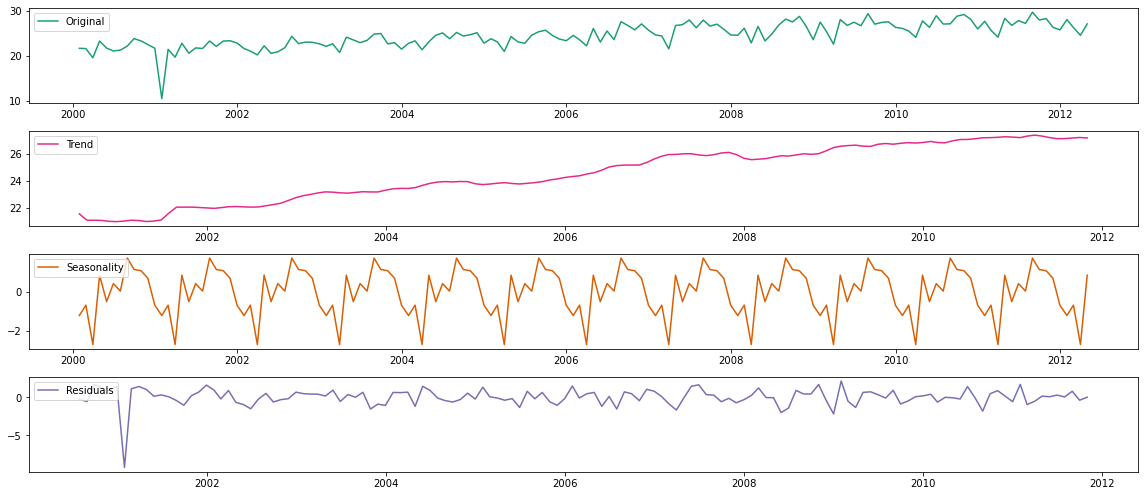

In [18]:

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

def breakout_plots(seas_series):
    decomposition = seasonal_decompose(seas_series) 

    f, ax = plt.subplots(1,4,figsize=(16, 7))

    plt.subplot(411)
    plt.plot(seas_series, label='Original', c=dark2_colors[0])
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', c=dark2_colors[1])
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(decomposition.seasonal,label='Seasonality', c=dark2_colors[2])
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals', c=dark2_colors[3])
    plt.legend(loc='upper left')
    plt.tight_layout()
    
    return decomposition

decomposition = breakout_plots(data_ts.Data)


### Stationary Time Series 

A stationary time series is one whose statistical properties such as *mean, variance, autocorrelation*, etc. are all constant over time. Most statistical **forecasting** methods are based on the assumption that the time series are weak stationary. When this is not the case, we can use this models after implementing certain mathematical transformations that render the time series stationary. 

There are 2 main reasons behind non-stationarity of a TS:

1. *Trend* – varying mean over time. 

2. *Seasonality* – variations at specific time-frames.

Notice that in our case, both of this patterns are spotted. In order to find statistical evidence that this is actually the case we run the Augmented Dickey-Fuller Test (ADF) test. The null hypothesis is that the TS is non-stationary. The test results comprise of a test statistic and some critical values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 

Last but not least, both the auctocorrelation function and the partial autocorrelation function can help us spot time series patterns.

Autocorrelation Function:

- Used to help identify possible structure of time series data. (Looking for periodicity - yearly,weekly etc)
- Gives a sense of how different points in time relate to each other in a way explained by temporal distance.
- Not a good idea if data is sampled at irregular intervals.
- Self-correlation or  in other words comparing the same series with itself at different lag values.

Partial Auto correlation function:
- Gives the partial correlation of a time series with its own lagged values, controlling for the values of time series at all shorter lags. (For lag 5, control 1-4 lags)

As we can see from the results below, the ADF test shows that our raw data is not stationary. 

In order to render it stationary, we will try working with the first difference the series in the remaining part of the exceicise.

In [19]:
useful_values_raw = adfuller(data_ts.Data, autolag = 'AIC', regression = 'c')
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({ 'Value':useful_values, 'Label':['Test Statistic','p-value','#Lags Used',
                                               'Number of Observations Used', 
                                               'Critical value for 1%', 'Critical value for 5%',
                                               'Critical value for 10%']})

,Value,Label
0,-1.593535,Test Statistic
1,0.486840,p-value
2,13.000000,#Lags Used
3,134.000000,Number of Observations Used
4,-3.480119,Critical value for 1%
5,-2.883362,Critical value for 5%
6,-2.578407,Critical value for 10%


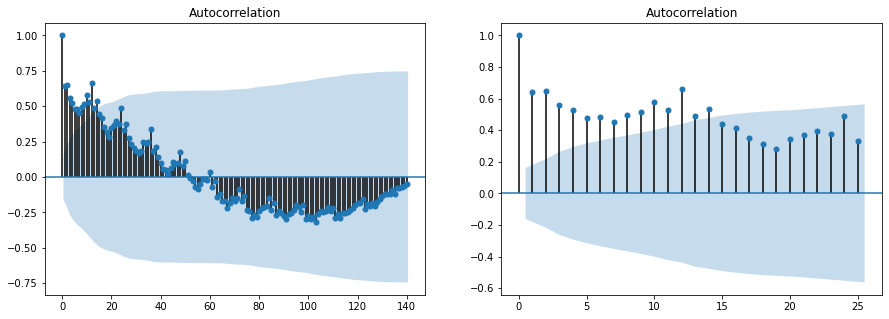

In [20]:
# Autocorrelation Function
f, axs = plt.subplots(1,2,figsize=(15,5))
plot_acf(data_ts['Data'],ax=axs[0], lags = 140); # 95% confidence interval
plot_acf(data_ts['Data'],lags=25, ax=axs[1]); # Limit the number of lags - See the peaks at 1st months

The autocorrelation function is used to help identify possible structure of time series data. The significant autocorrelation at lag 1 month is probably due to the increasing trend over the period of the data. Usually a trend in the data will show in the correlogram as a slow decay in the autocorrelations, due to similar values in the series occurring close together in time. This is clearly evidenced in the charts above.

In order to find the time series model that best fits the data and based on the results we showed in the previous step, we first need to render our data stationary. 
Thus, we decided to apply the log function, compute the difference and calculate the ACF and PACF and then run the SDF test. The resuls are shown below.

In [46]:
# Take log Data
data_ts['log_data'] = np.log(data_ts['Data'])

In [56]:
def tsplot(y, lags=None, figsize=(12, 12)):
    
    q, p = sm.stats.diagnostic.acorr_ljungbox(y,lags)
    
    fig = plt.figure(figsize=figsize)
    layout = (4, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    qq_ax = plt.subplot2grid(layout, (2, 0), colspan=2, title='QQ plot')
    lbox_ax = plt.subplot2grid(layout, (3, 0), colspan=2, title='Ljung-Box statistic')

    y.plot(ax=ts_ax, title='Residuals')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

    qqplot(y,  line='q', ax=qq_ax, fit=True)
    if np.max(p) > 0.05:
        lbox_ax.axhline(y=0.05, xmin=0, xmax=lags, c ='r')
    lbox_ax.plot(p)
    sns.despine()
    plt.tight_layout()
    
    return ts_ax, acf_ax, pacf_ax, lbox_ax

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


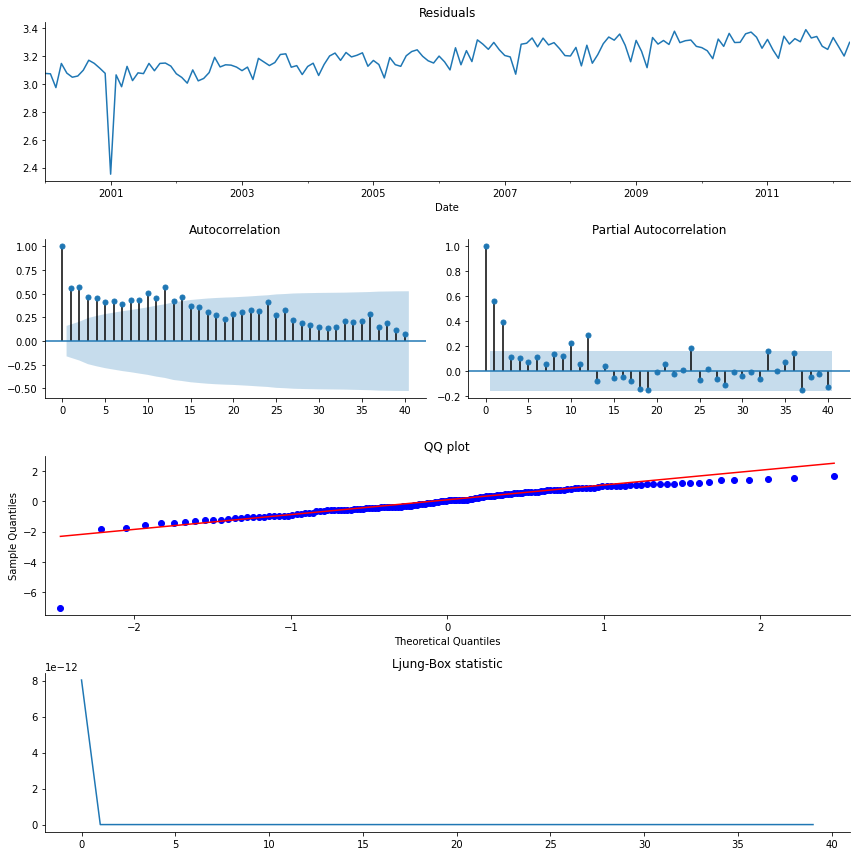

In [57]:
_ = tsplot(data_ts['log_data'] , 40)

In [58]:
# Apply dif data_ts.Data
data_ts['log_data_diff'] = np.log(data_ts['Data']).diff()

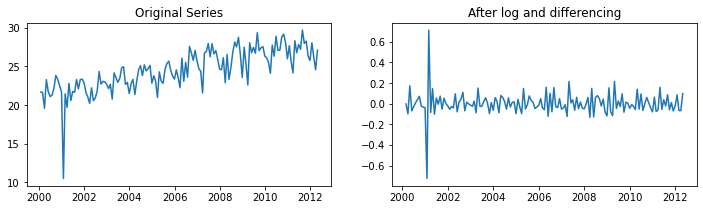

In [59]:
#Plot the data
f, ax = plt.subplots(1, 2,figsize=(12, 3))
ax[0].plot(data_ts['Data']);
ax[0].set_title('Original Series')
ax[1].plot(data_ts['log_data_diff']);
ax[1].set_title('After log and differencing');

In [60]:
data_ts.dropna(inplace = True)
data_ts.head()

,Data,log_data,log_data_diff
Date,,,
2000-02-29,21.622112,3.073717,-0.002893
2000-03-31,19.583297,2.974677,-0.099040
2000-04-30,23.290602,3.148050,0.173373
2000-05-31,21.729621,3.078676,-0.069374
2000-06-30,21.098816,3.049217,-0.029459


In [64]:
useful_values_raw = adfuller(data_ts.log_data_diff, autolag = 'AIC', regression = 'c')
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({ 'Value':useful_values, 'Label':['Test Statistic','p-value','#Lags Used',
                                               'Number of Observations Used', 
                                               'Critical value for 1%', 'Critical value for 5%', 
                                               'Critical value for 10%']})


,Value,Label
0,-8.388911e+00,Test Statistic
1,2.396148e-13,p-value
2,1.200000e+01,#Lags Used
3,1.340000e+02,Number of Observations Used
4,-3.480119e+00,Critical value for 1%
5,-2.883362e+00,Critical value for 5%
6,-2.578407e+00,Critical value for 10%


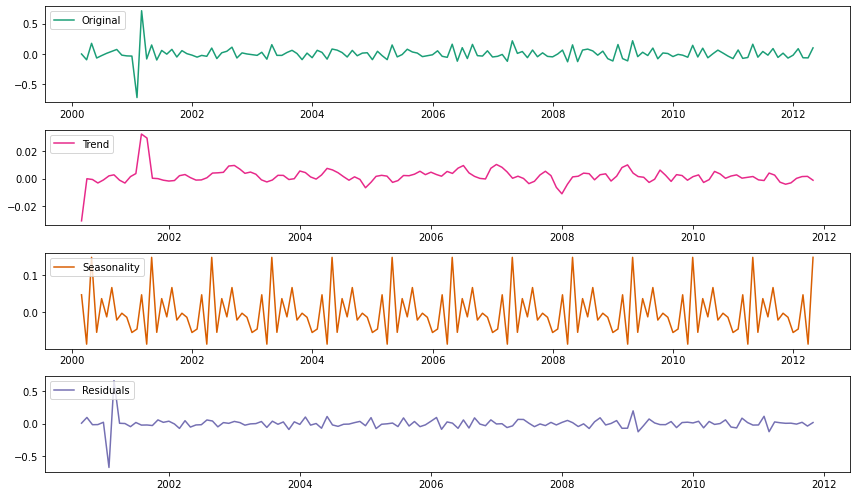

In [65]:
def breakout_plots(seas_series):
    decomposition = seasonal_decompose(seas_series) 

    f, ax = plt.subplots(1,4,figsize=(12, 7))

    plt.subplot(411)
    plt.plot(seas_series, label='Original', c=dark2_colors[0])
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', c=dark2_colors[1])
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(decomposition.seasonal,label='Seasonality', c=dark2_colors[2])
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals', c=dark2_colors[3])
    plt.legend(loc='upper left')
    plt.tight_layout()
    
    return decomposition

decomposition = breakout_plots(data_ts['log_data_diff'])

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


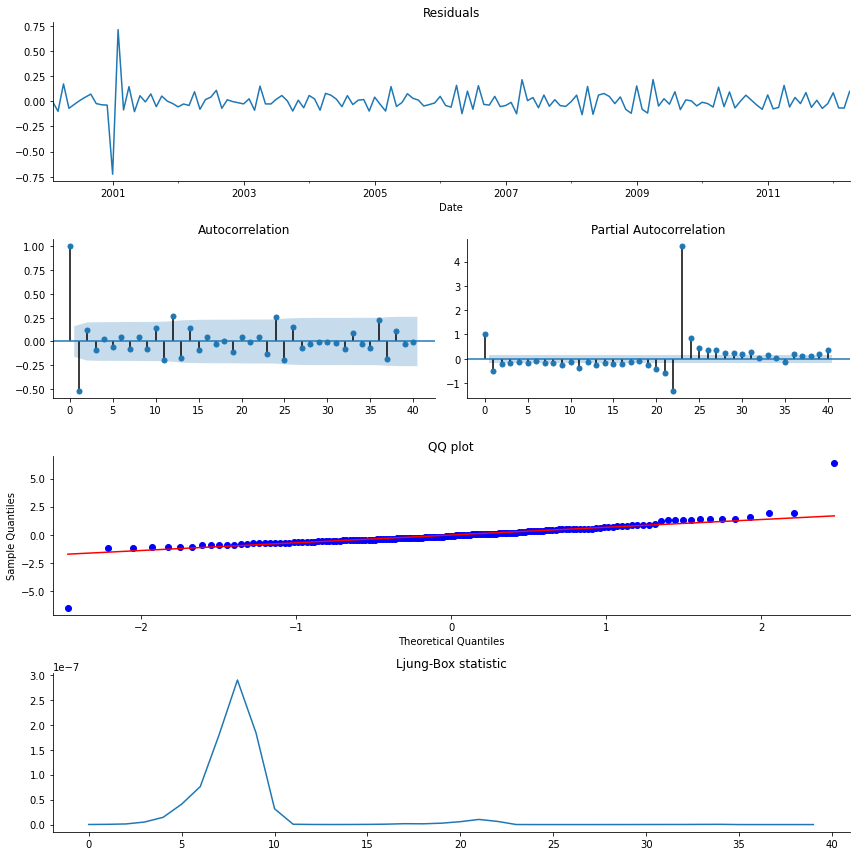

In [66]:
_ = tsplot(data_ts['log_data_diff'] , 40)

Notice that after the log transformation and calculating the difference between periods, the data is stationary. However, it is very clear that the outlier could stil influence the final results. 

In [88]:
# Fit an ARIMA (0,1,1) model to the log_data including an intercept
arima_mod = ARIMA(data_ts['log_data'], freq='M', order=(0,1,1))
results_ARIMA = arima_mod.fit(disp=False)
print(results_ARIMA .summary())

                             ARIMA Model Results                              
Dep. Variable:             D.log_data   No. Observations:                  146
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 152.911
Method:                       css-mle   S.D. of innovations              0.083
Date:                Tue, 06 Apr 2021   AIC                           -299.823
Time:                        19:30:04   BIC                           -290.872
Sample:                    03-31-2000   HQIC                          -296.186
                         - 04-30-2012                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0020      0.000     12.379      0.000       0.002       0.002
ma.L1.D.log_data    -1.0000      0.027    -36.548      0.000      -1.054      -0.946
                            

As we can see from the plots below, the residuals of the model show that errors follow no pattern and lack autocorrelation. However, both the =the chart from the residuals, the qq plot and the Ljung box statistic suggest the existence of outliers which should be addressed before this model is out into use.

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


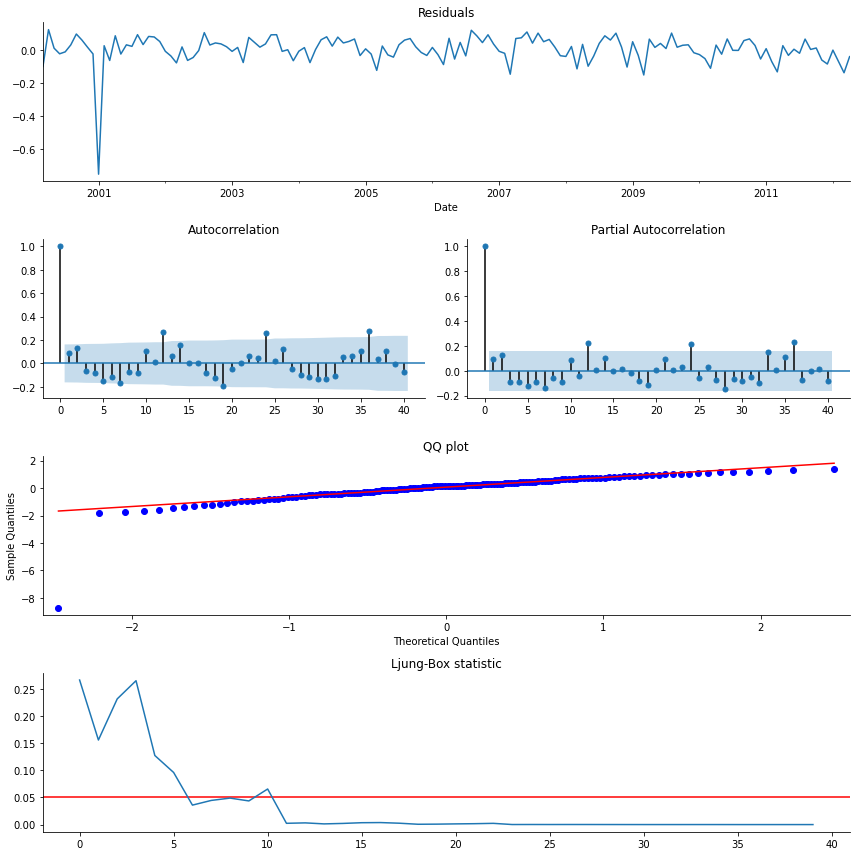

In [89]:
_ = tsplot(results_ARIMA .resid, 40)

Notice that the outlier should be looked into before implementing this model to forecast. Maybe using a dummy variable is enough.